# Exploratory Data Analysis (EDA)

In diesem Notebook wird der bereinigte Datensatz explorativ analysiert, um ein grundlegendes Verständnis der Feature-Verteilungen und Zusammenhänge zu gewinnen.  
Die gewonnenen Erkenntnisse dienen als Grundlage für das Feature Engineering und die Modellierung in den folgenden Notebooks.

## Gliederung

In diesem Notebook wird die explorative Datenanalyse schrittweise durchgeführt:

### 1. Daten laden & Überblick  
   - Importieren der benötigten Bibliotheken
   - Laden der Daten aus Notebook_01
   - Erster Überblick mit .head() und .info()

### 2. Analyse numerischer Features
   - Überblick mit .describe()
   - Kontinuierliche Features
   - Diskrete Features

### 4. Analyse kategorialer Features
   - Low-cardinality Features  
   - High-cardinality Features

### 5. Feature-Relevanz mit Mutual Information
   - Definieren einer Funktion für Mutual Information
   - Anwendung der Funktion und Interpretation

### 6. Pairplots
   - Erstellen von Pairplots für numerische Features

### 7. Zusammenhänge zwischen kategorialen Features
   - Defininieren einer Funktion für Cramers'V
   - Erstellen einer Heatmap für Cramers'V
     
### 8. Entfernen von car_name und Speichern

## Daten Laden und Überblick
### Importieren der benötigten Bibliotheken

In [14]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_regression

%config InlineBackend.figure_format = 'retina'
sns.set_theme(style='whitegrid')
plt.rc('figure', autolayout = True, dpi = 110)
plt.rc('axes', labelweight = 'bold', titlesize = 14, titleweight = 'bold')
plt.rc('font', size = 11)

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

### Laden der Daten aus Notebook_01

In [29]:
data_dir = Path('data/processed')
data_file = data_dir / 'cleaned_data_01.csv'
df = pd.read_csv(data_file)
print(df.shape)

(7391, 19)


### Erster Überblick mit .head() und .info()

In [16]:
df.head()

,car_name,fuel_type,kms_run,sale_price,city,body_type,transmission,variant,registered_city,registered_state,rto,make,model,total_owners,original_price,car_rating,fitness_certificate,warranty_avail,age
0,maruti swift,petrol,8063,386399,noida,hatchback,manual,lxi opt,delhi,delhi,dl6c,maruti,swift,2,404177.0,great,True,False,6
1,maruti alto 800,petrol,23104,265499,noida,hatchback,manual,lxi,noida,uttar pradesh,up16,maruti,alto 800,1,354313.0,great,True,False,5
2,hyundai grand i10,petrol,23402,477699,noida,hatchback,manual,sports 1.2 vtvt,agra,uttar pradesh,up80,hyundai,grand i10,1,NaN,great,True,False,4
3,maruti swift,diesel,39124,307999,noida,hatchback,manual,vdi,delhi,delhi,dl1c,maruti,swift,1,374326.0,great,True,False,8
4,hyundai grand i10,petrol,22116,361499,noida,hatchback,manual,magna 1.2 vtvt,new delhi,delhi,dl12,hyundai,grand i10,1,367216.0,great,True,False,6


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7391 entries, 0 to 7390
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   car_name             7391 non-null   object 
 1   fuel_type            7391 non-null   object 
 2   kms_run              7391 non-null   int64  
 3   sale_price           7391 non-null   int64  
 4   city                 7391 non-null   object 
 5   body_type            7391 non-null   object 
 6   transmission         7391 non-null   object 
 7   variant              7391 non-null   object 
 8   registered_city      7391 non-null   object 
 9   registered_state     7391 non-null   object 
 10  rto                  7391 non-null   object 
 11  make                 7391 non-null   object 
 12  model                7391 non-null   object 
 13  total_owners         7391 non-null   int64  
 14  original_price       4120 non-null   float64
 15  car_rating           7391 non-null   o

## Analyse numerischer Features

In diesem Abschnitt untersuchen wir die Verteilung der numerischen Features sowie mögliche Ausreißer, um ein besseres Verständnis ihrer Skalen und Verteilungen zu gewinnen.

### Überblick mit .describe()

In [18]:
df.describe()

,kms_run,sale_price,total_owners,original_price,age
count,7391.000000,7.391000e+03,7391.000000,4.120000e+03,7391.000000
mean,62622.812745,4.552219e+05,1.326343,5.510351e+05,7.106751
std,43549.127642,2.826614e+05,0.578700,3.119887e+05,3.078951
min,60.000000,0.000000e+00,1.000000,9.689900e+04,0.000000
25%,31853.500000,2.814990e+05,1.000000,3.414930e+05,5.000000
50%,55752.000000,3.826990e+05,1.000000,4.674800e+05,7.000000
75%,84187.000000,5.403990e+05,2.000000,6.675258e+05,9.000000
max,996609.000000,3.866000e+06,6.000000,2.765057e+06,25.000000


Ein erster Blick auf die deskriptiven Statistiken legt keine offensichtlich fehlerhaften Ausreißer nahe.  
Hohe Kilometerstände sowie hohe Verkaufs- und Originalpreise erscheinen im Kontext des Datensatzes plausibel, ebenso wie eine maximale Anzahl von sechs Vorbesitzern.

Insgesamt deuten die Kennzahlen darauf hin, dass die numerischen Features realistische Wertebereiche abdecken.

### Kontinuierliche Features

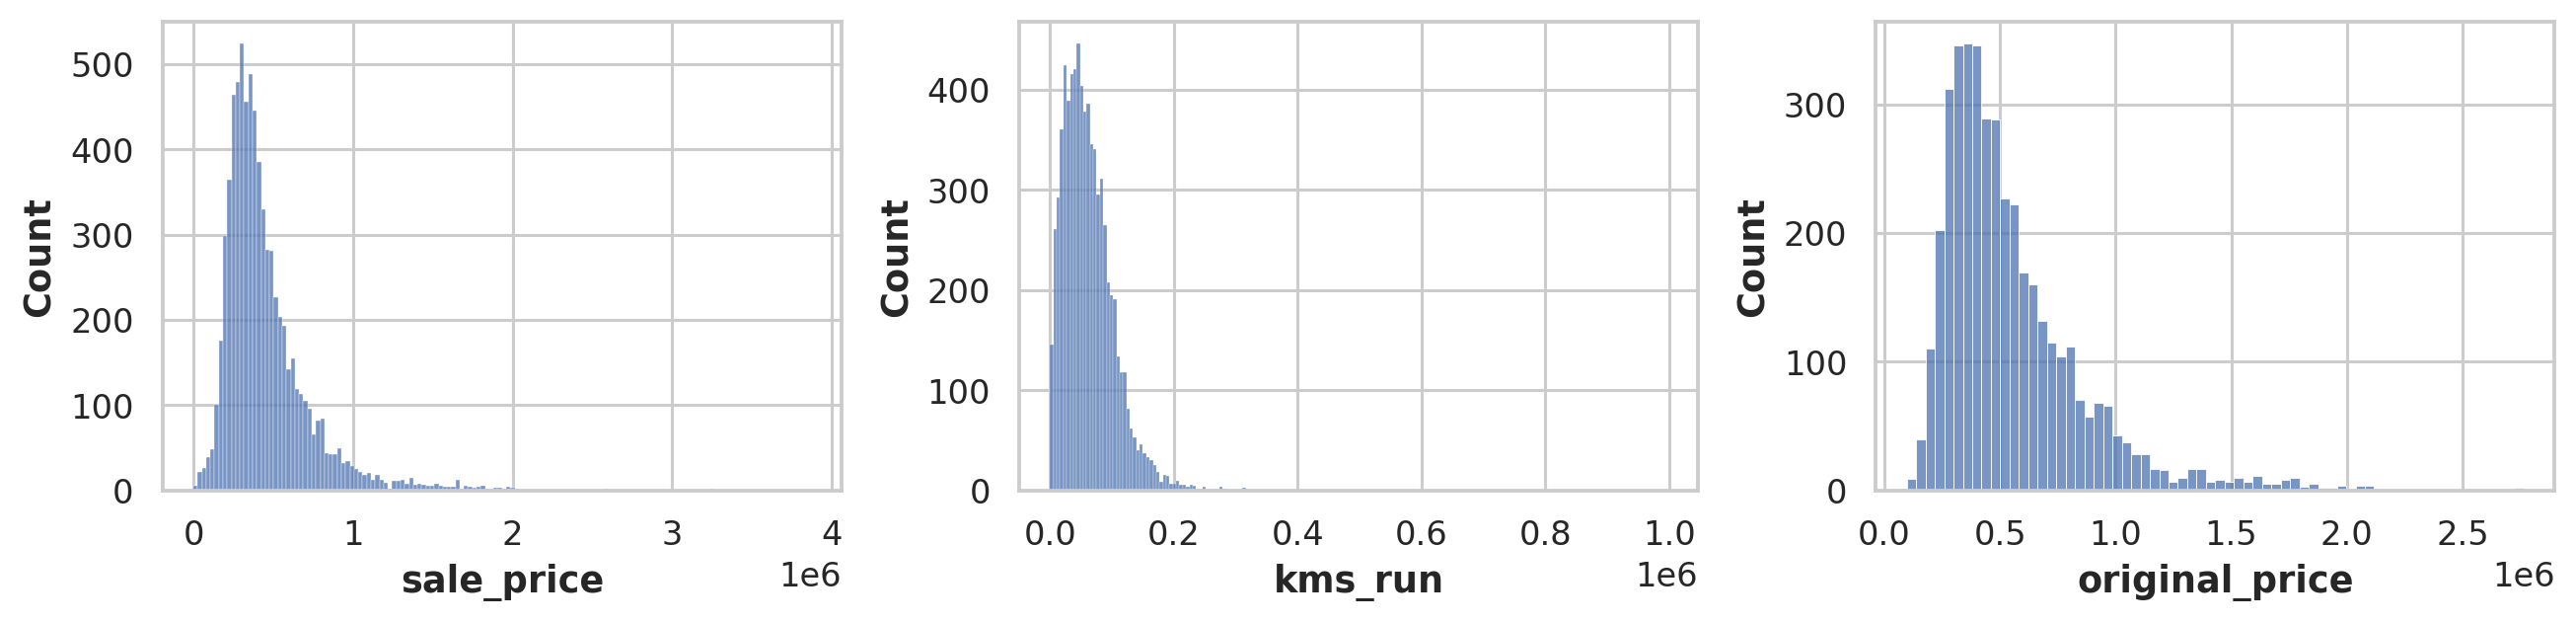

In [30]:
#Filtern von kontinuierlichen Features
cont_nums = ['sale_price', 'kms_run', 'original_price']

#Plotten wir die Verteilung unserer kontinuierlichen Features mit Histogrammen
plt.figure(figsize = (12,3))
for index, col in enumerate(cont_nums):
    plt.subplot(1, 3, index+1)
    sns.histplot(df[col])

Wie zu erwarten zeigen die kontinuierlichen Features stark rechtsschiefe Verteilungen.  
Insbesondere weist `original_price` eine sehr ähnliche Verteilungsform wie `sale_price` auf, was auf eine enge inhaltliche Beziehung zwischen beiden Variablen hindeutet.

### Diskrete Features

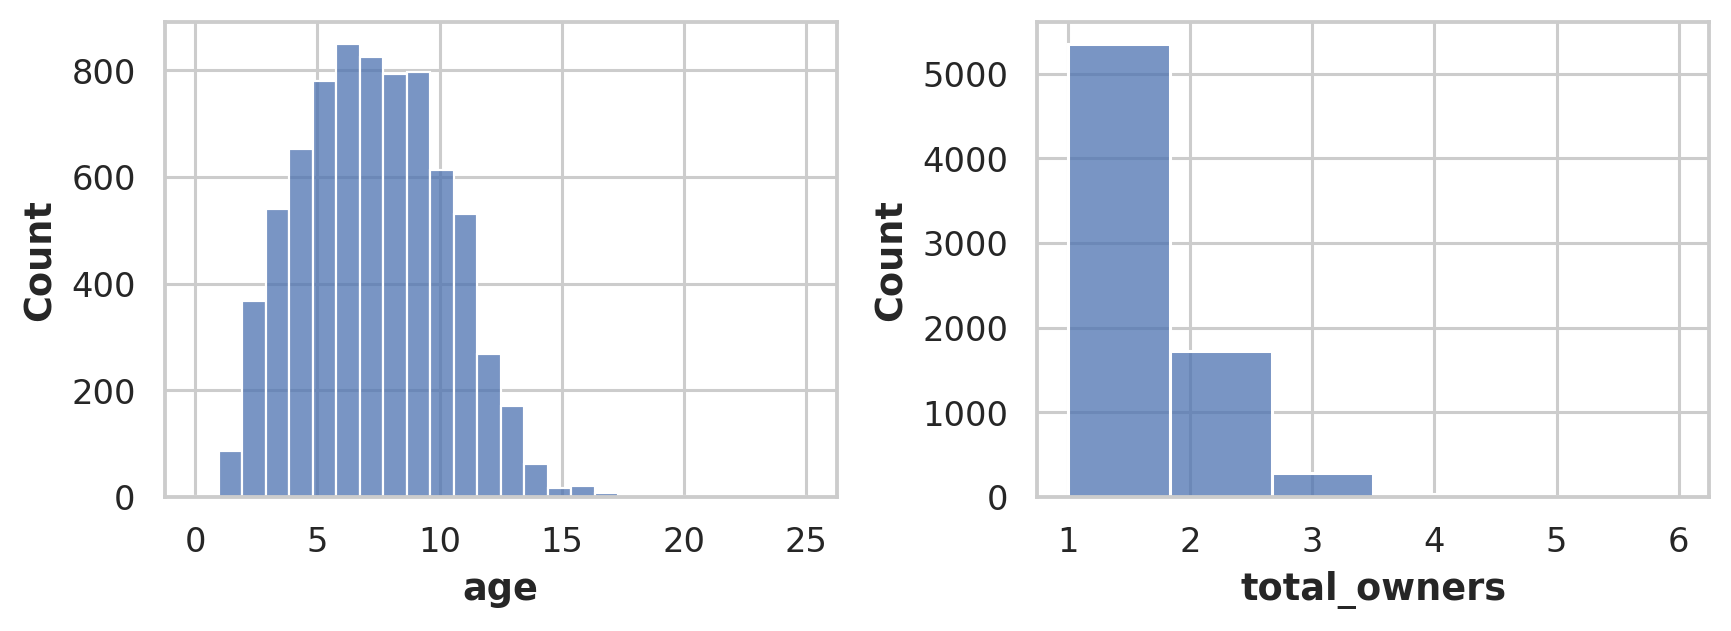

In [31]:
disc_nums = ['age', 'total_owners']
plt.figure(figsize = (8, 3))
for index, col in enumerate(disc_nums):
    plt.subplot(1, 2, index +1)
    bins = df[col].max() - df[col].min() + 1
    sns.histplot(x = df[col], bins = bins)

Die diskreten numerischen Features `age` und `total_owners` werden separat betrachtet, da sie trotz numerischer Kodierung einen begrenzten und interpretierbaren Wertebereich besitzen.  
Während sich das Fahrzeugalter relativ breit verteilt, zeigt `total_owners` eine stark rechtsschiefe Verteilung, wobei die Mehrheit der Fahrzeuge ein oder zwei Vorbesitzer hatte.


## Analyse kategorischer Features

Für die Visualisierung trennen wir kategoriale Variablen nach ihrer **Kardinalität**:

### Low-cardinality Features
**Low-cardinality** Features werden vollständig als Countplots dargestellt.

In [32]:
cat_cols = df.select_dtypes(include = ['object', 'bool'])
high_kard_cols = []
low_kard_cols = []
for col in cat_cols:
    if df[col].nunique() > 20:
        high_kard_cols.append(col)
    else:
        low_kard_cols.append(col)
print(len(low_kard_cols))

8


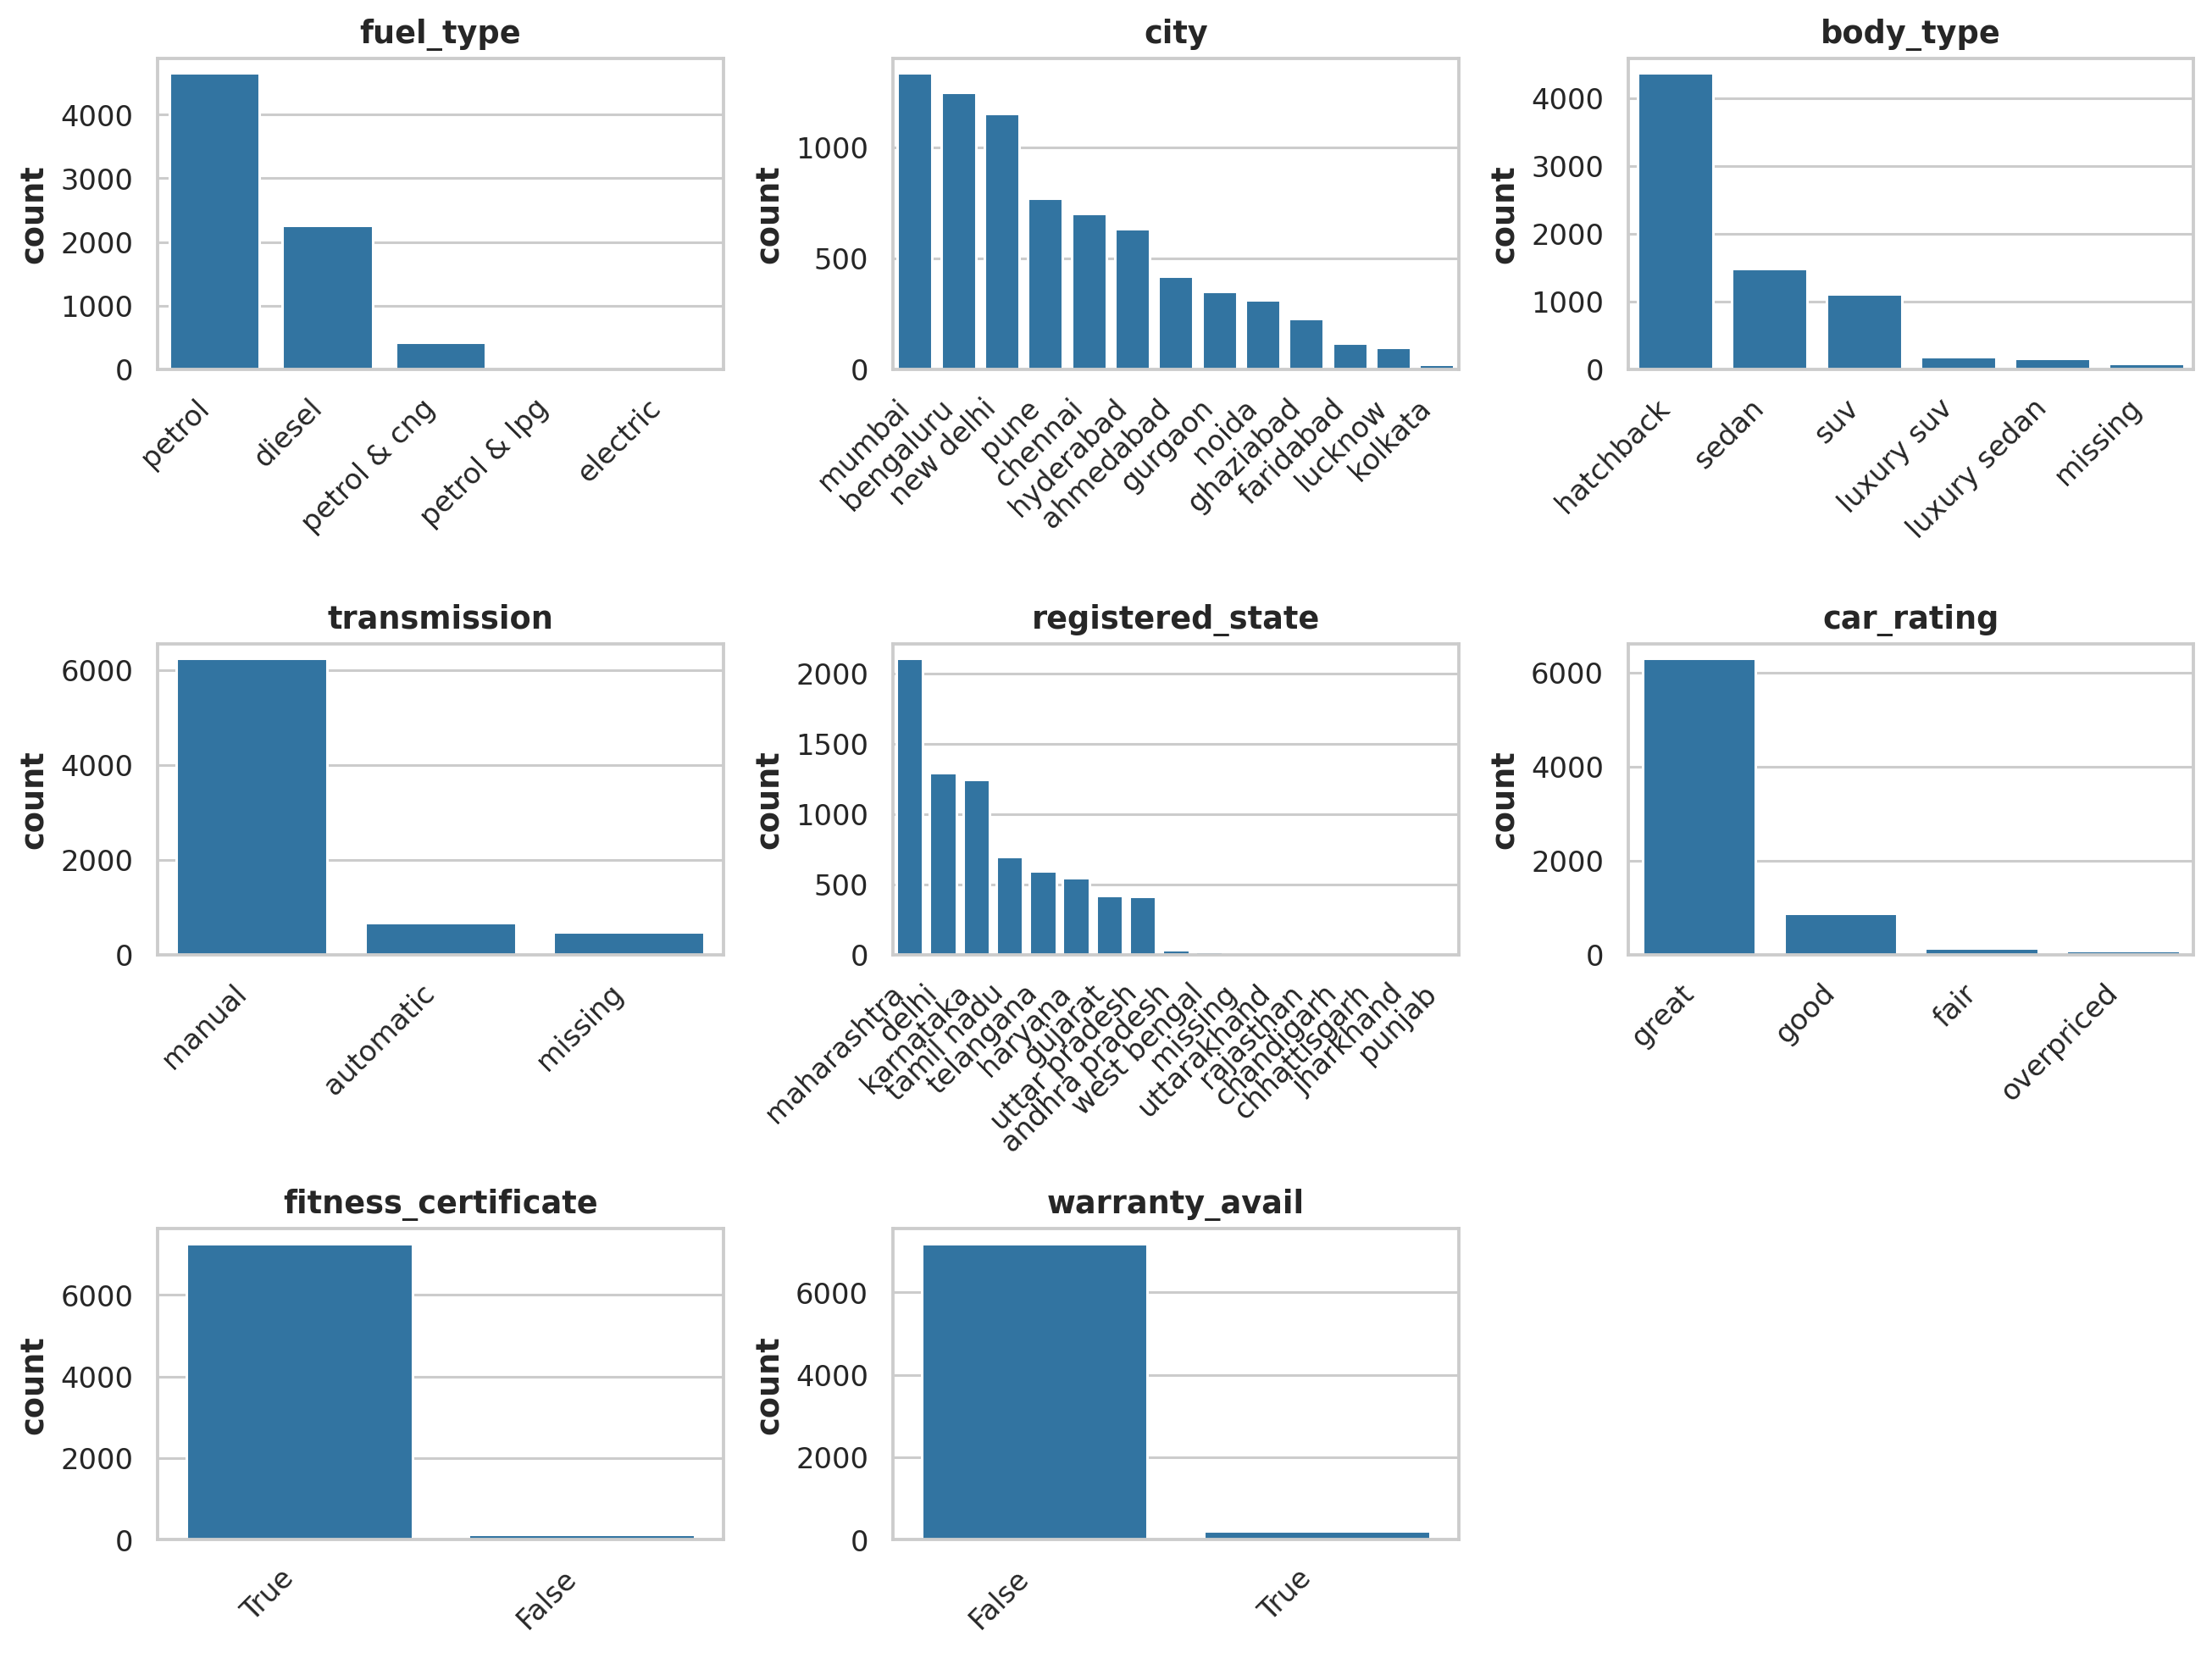

In [33]:
plt.figure(figsize = (12,9))
for index, col in enumerate(low_kard_cols):
    plt.subplot(3, 3, index +1)
    order = df[col].value_counts().index
    sns.countplot(x= df[col], color = '#1f77b4', order = order)
    plt.title(col, fontsize = 12)
    plt.xticks(rotation = 45, ha = 'right')
    plt.xlabel('')

- **Kraftstoff:** Petrol dominiert, gefolgt von Diesel; alternative Antriebe (z. B. CNG/Electric) sind selten.
- **Karosserie:** Hatchback und Sedan sind am häufigsten; SUVs und „Luxury“-Typen treten deutlich seltener auf.
- **Getriebe:** Manuelle Getriebe überwiegen gegenüber Automatik.
- **Region:** Die meisten Einträge stammen aus wenigen Städten (z. B. Mumbai, New Delhi, Bengaluru).
- **Zustand/Rating:** Bewertungen sind stark unausgeglichen und konzentrieren sich auf positive Kategorien (v. a. „great“, „good“).
- **Zertifikat & Garantie:** Ein Fitness-Zertifikat ist häufig vorhanden; Garantien sind vergleichsweise selten.

### High-cardinality Features
**High-cardinality** Features werden auf die **Top-10 Kategorien** reduziert, um die Verteilungen trotz vieler Ausprägungen interpretierbar zu halten.

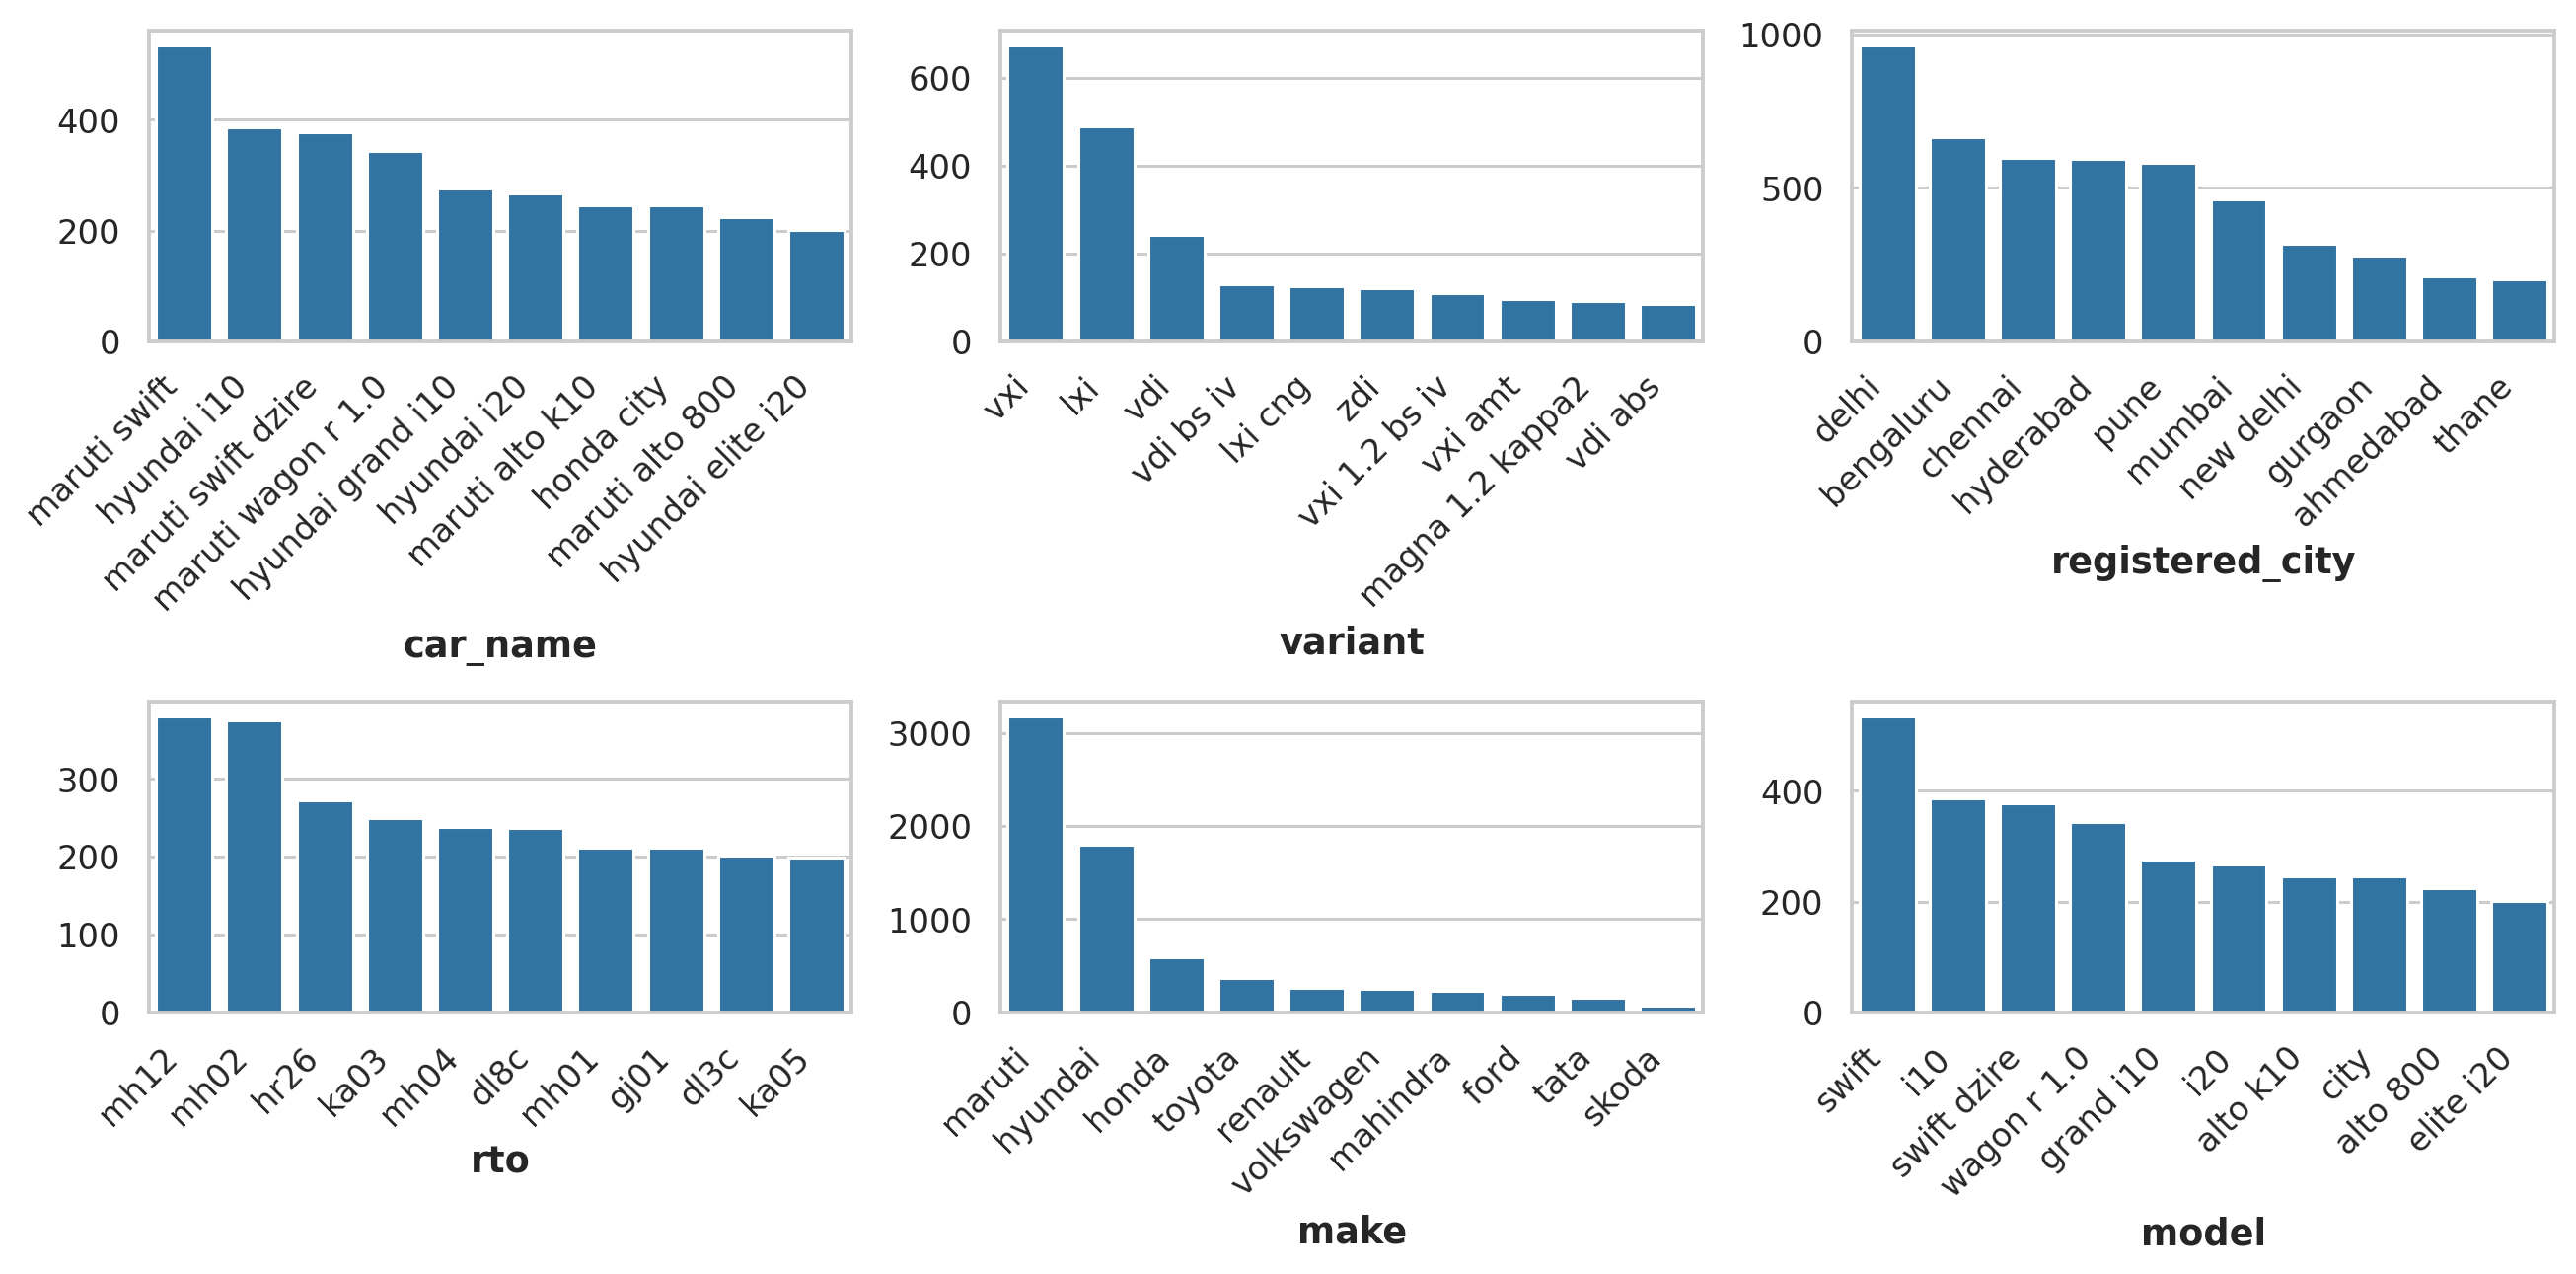

In [34]:
plt.figure(figsize = (12,6))
for index, col in enumerate(high_kard_cols):
    plt.subplot(2, 3, index + 1)
    high_freq = df[col].value_counts().nlargest(10)
    sns.barplot(x=high_freq.index, y=high_freq.values, color = '#1f77b4')
    plt.xticks(rotation=45, ha='right')

Die Features **make**, **model**, **variant**, **registered_city** und **rto** zeigen eine klare Konzentration auf wenige häufige Kategorien.  
Insbesondere **make** und **variant** werden von einzelnen Werten (z. B. Maruti, VXI) dominiert, während viele andere Ausprägungen nur selten vorkommen.

Die Features **registered_city** und **rto** sind insgesamt etwas gleichmäßiger verteilt, zeigen jedoch ebenfalls eine Konzentration auf wenige große Städte bzw. Regionen.  
Das Feature **car_name** stellt im Wesentlichen eine Kombination aus **make** und **model** dar und liefert daher nur begrenzte zusätzliche Information, was auf Redundanz hindeutet.

## Feature-Relevanz mit Mutual Information

### Definieren einer Funktion für Mutual Information

In [35]:
def get_mutual_info(data, target):
    X = data.copy().drop(columns = 'original_price')
    y = X.pop(target)

    #Kategorische Features in ein numerisches Format bringen:
    for col in X.select_dtypes('object'):
        X[col], _ = X[col].factorize()

    mi_scores = mutual_info_regression(X, y, discrete_features = True)
    mi_scores = pd.Series(mi_scores, name = 'MI-Scores', index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)

    print(mi_scores)

    if 'original_price' in data.columns:
        X2 = data[['original_price', 'sale_price']].copy()
        X2 = X2.dropna()
        y2 = X2.pop('sale_price')
        mi_scores = mutual_info_regression(X2, y2)
        mi_scores = pd.Series(mi_scores, name = 'MI-Scores', index = X2.columns)
        print(mi_scores)

### Anwendung der Funktion und Interpretation

In [36]:
get_mutual_info(df, 'sale_price')

variant                0.901509
car_name               0.814083
model                  0.814083
age                    0.365209
body_type              0.240529
make                   0.139436
fuel_type              0.111795
car_rating             0.104798
rto                    0.078906
transmission           0.071377
fitness_certificate    0.050401
registered_city        0.050240
city                   0.036838
registered_state       0.034949
total_owners           0.023428
kms_run                0.007729
warranty_avail         0.003605
Name: MI-Scores, dtype: float64
original_price    2.376489
Name: MI-Scores, dtype: float64


Die univariate Mutual-Information-Analyse zeigt, dass insbesondere die Features **variant**, **car_name** und **model** den stärksten Zusammenhang mit dem Verkaufspreis aufweisen.  
Dieses Ergebnis ist konsistent mit der vorherigen Analyse, da diese Variablen zentrale Informationen über Fahrzeugtyp und -ausstattung enthalten.

Auffällig ist zudem der sehr hohe Mutual-Information-Score von **original_price**.  
Dies deutet auf eine starke Abhängigkeit zum Target hin und legt nahe, dass dieses Feature entweder sehr eng mit dem Verkaufspreis verknüpft ist oder teilweise redundante Information enthält.

Da keine weiteren Informationen zur Datenerhebung vorliegen, wird diese Beobachtung im nächsten Schritt weiter untersucht, um mögliche Redundanzen oder Leckage-Effekte besser einordnen zu können.

## Pairplots

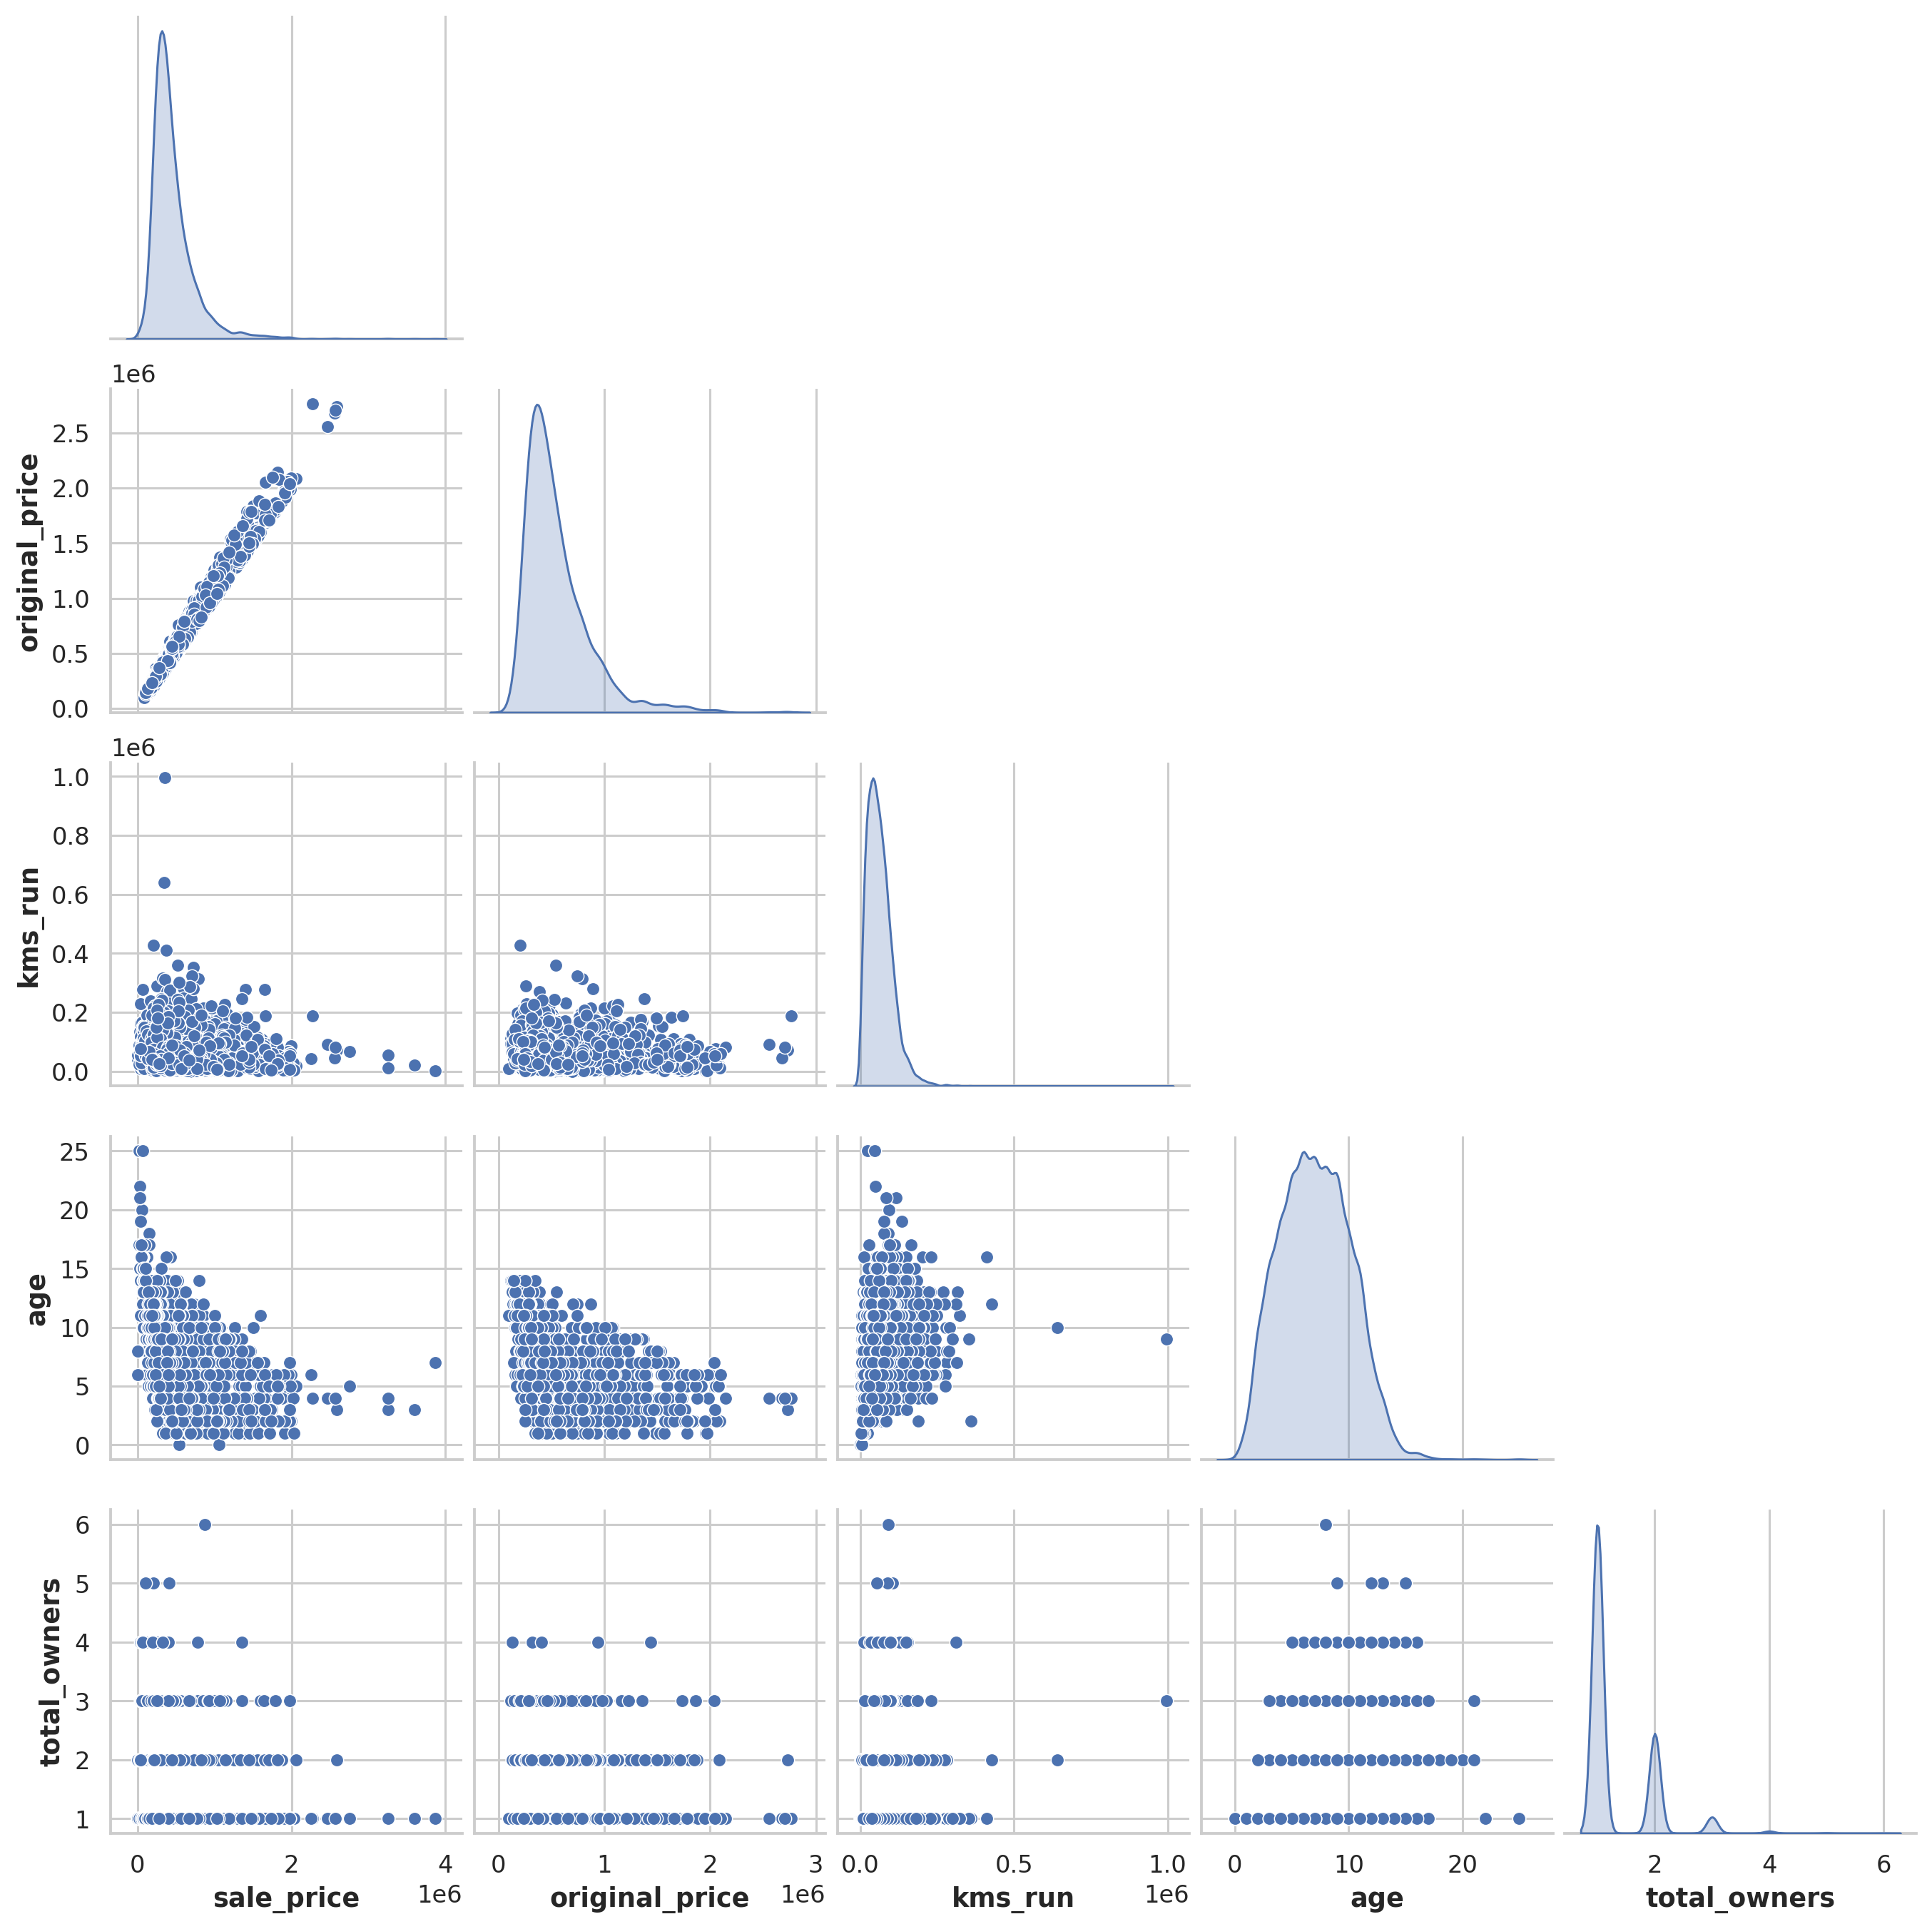

In [37]:
sns.pairplot(df[['sale_price', 'original_price', 'kms_run', 'age', 'total_owners']], corner = True, diag_kind = 'kde')

Der Pairplot bestätigt meine Vermutung. Der Zusammenhang zwischen original_price und sale_price ist zu linear um natürlichen Ursprungs zu sein.
Die Verwendung des Features würde vermutlich zu sehr genauen Vorhersagen unseres Modells führen. In der Realität wird der Ursprüngliche Preis häufig bekannt sein und er sollte auch ein guter Indikator für den Wiederverkaufswert sein. Allerdings sollten die anderen Eigenschaften wie Alter, Zustand etc höhere Schwankungen im Zusammenhang zwischen original_price und sale_price verursachen. Aus diesem Grund werde ich bei meinem weiteren Verfahren original_price zuerst weglassen.

In [38]:
df = df.drop(columns = 'original_price')

## Zusammenhänge zwischen kategorialen Features

In diesem Abschnitt untersuchen wir die Zusammenhänge zwischen den kategorischen Features. Da klassische Korrelationen für nominale Variablen ungeeignet sind, verwenden wir Cramér’s V als Maß für die Stärke des Zusammenhangs zwischen zwei kategorialen Merkmalen.

### Defininieren einer Funktion für Cramers'V

In [39]:
def cramers_v(X, y):
    confusion_matrix = pd.crosstab(X, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape

    phi2corr = max(0, phi2 - ((k - 1)*(r - 1))/(n - 1))
    rcorr = r - ((r - 1)**2)/(n - 1)
    kcorr = k - ((k - 1)**2)/(n - 1)

    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

### Erstellen einer Heatmap für Cramers'V

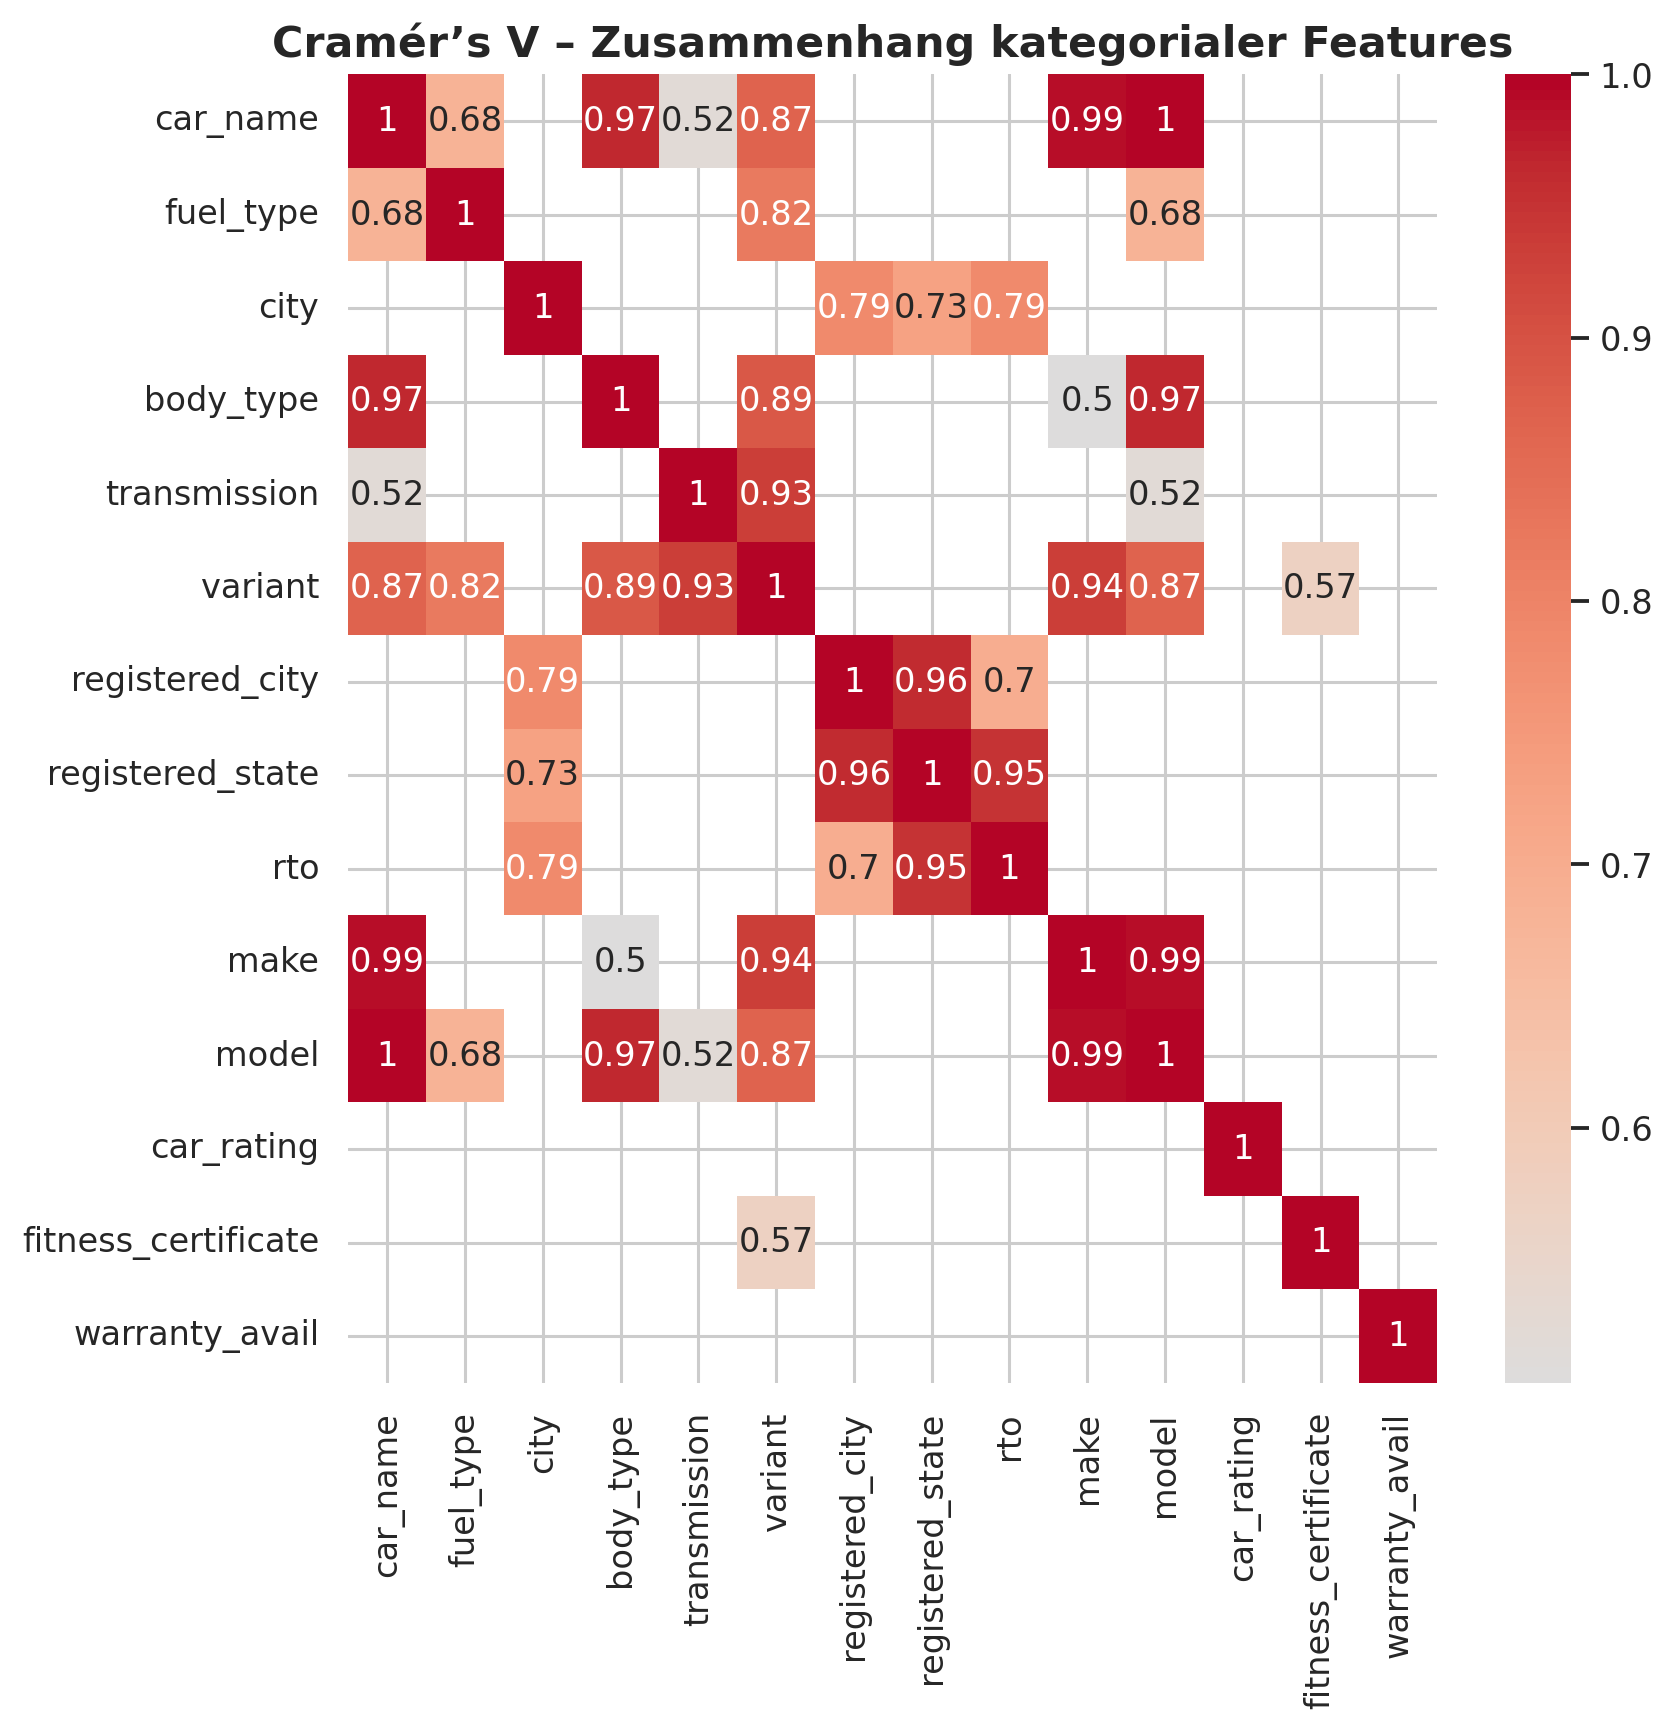

In [40]:
cats = df.select_dtypes(['object', 'bool']).columns
cramers = pd.DataFrame(index=cats, columns=cats)

for col1 in cats:
    for col2 in cats:
        cramers.loc[col1, col2] = cramers_v(df[col1], df[col2])

cramers = cramers.astype(float)
plt.figure(figsize = (8,8))
mask = abs(cramers < 0.5)
sns.heatmap(cramers, annot=True, cmap="coolwarm", center=0.5, mask = mask)
plt.title("Cramér’s V – Zusammenhang kategorialer Features")
plt.show()

In [41]:
for col in df.select_dtypes('object'):
    print(f'Anzahl Kategorien in {col}: {df[col].nunique()}')

Anzahl Kategorien in car_name: 184
Anzahl Kategorien in fuel_type: 5
Anzahl Kategorien in city: 13
Anzahl Kategorien in body_type: 6
Anzahl Kategorien in transmission: 3
Anzahl Kategorien in variant: 939
Anzahl Kategorien in registered_city: 244
Anzahl Kategorien in registered_state: 17
Anzahl Kategorien in rto: 261
Anzahl Kategorien in make: 27
Anzahl Kategorien in model: 184
Anzahl Kategorien in car_rating: 4


- Sehr hohe Cramér’s-V-Werte zwischen **make**, **model** und **car_name** bestätigen,
  dass diese Features stark redundant sind.
- **car_name** ist im Wesentlichen eine Kombination aus **make** und **model** und liefert
  daher kaum zusätzliche Information.
- Auch **variant** zeigt starke Zusammenhänge mit **model** und **make**, was auf eine
  inhaltliche Überlappung hindeutet.
- Regionale Merkmale wie **registered_city**, **registered_state** und **rto** sind
  untereinander stark korreliert.
- Features wie **fuel_type**, **transmission** oder **car_rating** weisen dagegen
  geringere Abhängigkeiten auf und liefern eher komplementäre Information.

## Entfernen von car_name und Speichern

In [42]:
#Verwerfen von car_name
df.drop(columns = 'car_name', inplace = True)

In [44]:
processed_dir = data_dir / 'processed'
processed_dir.mkdir(exist_ok = True)
df.to_csv(processed_dir / "cleaned_data_02.csv", index=False)